# Class 6 metrics

The class 6 corresponds to microlensing events (see https://en.wikipedia.org/wiki/Gravitational_microlensing for an explanation)

What is presented here is a method to fit the data with the theoretical model.
Output of the fit can then be employed as features for classification.

### The fit parameters are :
- The baseline of the model (one per band), corresponding to the flux before amplification
- The amplitude at maximum (one per band)
- The time of maximum
- The Einstein time, reprensenting the duration of the event
- The Wings parameter, representing the curtosis of the curve, and linked to the physical configuraiton of the event

### Two other numbers are given by the fit :
- The chi2
- NDF, number of degrees of freedom

### How to best use these numbers for classification :
- For members of the class, chi2/NDF should be peaked around 1, while it should be wildly above one for non-members. This is a goodness of fit metric, meaning that an outlier reaching 
chi2/NDF~1 is undistinguishable from a class member. A few class member will have chi2/NDF>>1: this happens when the fit fails.
- The fit parameters will exhibit the population statistics. Their distribution can be different between ddf=0 or ddf=1, or between training and test sets. They can help to distinguish class members from natural false-positives (like members of class 65)

This notebook will present the computation of these parameter, and save them in a local file.

## Read data and prepare some stuff

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

In [2]:
train_series = pd.read_csv('../input/training_set.csv')
train_metadata = pd.read_csv('../input/training_set_metadata.csv')

In [3]:
groups = train_series.groupby(['object_id', 'passband'])
times = groups.apply(
    lambda block: block['mjd'].values).reset_index().rename(columns={0: 'seq'})
flux = groups.apply(
    lambda block: block['flux'].values
).reset_index().rename(columns={0: 'seq'})
err = groups.apply(
    lambda block: block['flux_err'].values
).reset_index().rename(columns={0: 'seq'})
det = groups.apply(
    lambda block: block['detected'].astype(bool).values
).reset_index().rename(columns={0: 'seq'})
times_list = times.groupby('object_id').apply(lambda x: x['seq'].tolist()).tolist()
flux_list = flux.groupby('object_id').apply(lambda x: x['seq'].tolist()).tolist()
err_list = err.groupby('object_id').apply(lambda x: x['seq'].tolist()).tolist()
det_list = det.groupby('object_id').apply(lambda x: x['seq'].tolist()).tolist()

In [4]:
object_list=times.groupby('object_id').apply(lambda x: x['object_id'].unique()[0]).tolist()

In [5]:
colors = ['purple', 'blue', 'green', 'orange', 'red', 'black']
def plot_one_object(obj_id,split=False,frequency=0):
    
    if split:
        fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(12, 8))
    else:
        ax=plt.gca()
    for band in range(len(colors)):
        if split:
            ax = axes[band // 3, band % 3]
        sample = train_series[(train_series['object_id'] == obj_id) & (train_series['passband']==band)]
        if frequency:
            phase=(sample['mjd'] * frequency ) % 1
        else:
            phase=sample['mjd']
        ax.errorbar(x=phase,y=sample['flux'],yerr=sample['flux_err'],c = colors[band],fmt='o',alpha=0.7)
        

In [6]:
gal_target=train_metadata[train_metadata['hostgal_photoz']==0.0]['target'].unique()
t_type={}
ddf_type={}
wdf_type={}
for t in gal_target:
    t_type[t] = train_metadata[(train_metadata['target']==t)].index
    ddf_type[t] = train_metadata[(train_metadata['target']==t) & (train_metadata['ddf']==1)].index
    wdf_type[t] = train_metadata[(train_metadata['target']==t) & (train_metadata['ddf']==0)].index
t_colors={6:'blue',16:'red',65:'orange',92:'green',53:'purple'}


### One example of the class

2486


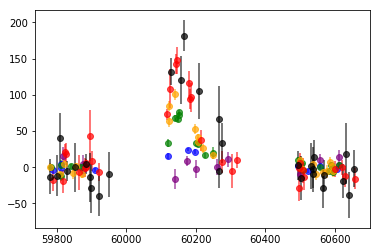

In [8]:
iobj=train_metadata[(train_metadata['target']==6) & (train_metadata['ddf']==0)]['object_id'].index[5]
    #plt.figure()
print(iobj)
plot_one_object(object_list[iobj])

### Theoretical microlensing curve

The amplitude depends on the angular separation $u$ as

$A(u) = \dfrac{u^2+2}{u \sqrt{u^2+4}}$

where $u$ depends on the time $t$ as

$u(t) = \sqrt{u^2_{min} + \dfrac{(t-t_0)^2}{t_E^2}}$

However, the data provided by PLAsTiCC do not include the base flux, 
so we need to infer 2 additional numbers : the baseline (flux outside the microlensing event)
and the amplification. 

Putting everything together, there are also pseudo-degeneracies, so I isolated them in 
the $w$ parameter representing the "wings" to help the convergence.

#### The final formula for the fit is then :
    
$F(t) = A S(\delta t) + B$

where $A$ is the amplitude, $B$ the baseline and  

$S(\delta t) = \dfrac{\dfrac{1 + \delta t^2 + w^2}{\sqrt{(1 + \delta t^2)(1+\delta t^2 + 2w^2)}}-1}
{\dfrac{1 + w^2}{\sqrt{1+2w^2}}-1}$

where $\delta t^2 = \dfrac{(t-t_0)^2}{t_E^2}$

In [10]:
# This is the formula from Wikipedia (not used here)

def microamp(t,params):
    (t0,te,umin)=params
    u = np.sqrt( umin**2 + ((t-t0)/te)**2 )
    amp = (u**2 + 2) / (u * np.sqrt(u**2+4))
    return amp

In [12]:
# This is the Shape function

def microshape(t,params):
    (t0,te,wings) = params
    tvec=((t-t0)/te)**2
    flux0 = 1.0 / ((1+wings**2) / (np.sqrt(1 + 2*wings**2)) -1)
    return flux0*((1 + tvec + wings**2) / np.sqrt((1+tvec)*(1+tvec+2*wings**2))-1)

#### A few examples...

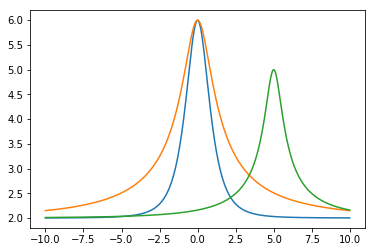

In [13]:
plt.plot(np.linspace(-10,10,300),microshape(np.linspace(-10,10,300),(0.0,1.0,np.sqrt(2.)))*4+2)
plt.plot(np.linspace(-10,10,300),microshape(np.linspace(-10,10,300),(0.0,1.0,np.sqrt(200)))*4+2)
plt.plot(np.linspace(-10,10,300),microshape(np.linspace(-10,10,300),(5.0,0.6,np.sqrt(200)))*3+2)

#### Coding the fit engine...

In [16]:
def fit_microlens(time,flux,err,paraminit=False):
    wmat=np.zeros((2,2))
    yvec=np.zeros(2)
    baseamp = np.zeros((6,2))
    
    def _chi2_microlens(params):
        (t0,te,wings) = params
        chi2 = 0
        for b in range(6):
            shape = microshape(time[b],(t0,te,wings)) 
            # now, predict value of base and amp.
            wmat[0][0] = np.sum(shape**2/err[b]**2)
            wmat[0][1] = wmat[1][0] = np.sum(shape/err[b]**2)
            wmat[1][1] = np.sum(1./err[b]**2)
            yvec[0] = np.sum(flux[b]*shape/err[b]**2)
            yvec[1] = np.sum(flux[b]/err[b]**2)
            try:
                baseamp[b] = np.linalg.inv(wmat).dot(yvec)
                baseamp[b][0] = np.max((baseamp[b][0],0))
            except:
                baseamp[b][0]=0
                baseamp[b][1]=np.sum(flux[b]/err[b]**2)/np.sum(1./err[b])
            
            chi2 += np.sum(( baseamp[b][0] * shape + baseamp[b][1] - flux[b] ) **2 / err[b]**2)
        
        return chi2
    
    if not paraminit:
        t0 = np.concatenate(time)[np.where(np.concatenate(flux)/np.concatenate(err)==np.max(np.concatenate(flux)/np.concatenate(err)))]
        te = 100.
        wings = 1.0
    else:
        (t0,te,wings) = paraminit
    
    #_chi2_microlens((t0,te,wings))
    #return (baseamp, (t0,te,wings))
    
    params=optimize.fmin(_chi2_microlens,(t0,te,wings),full_output=1,disp=0)
    return (baseamp,params[0], params[1],np.sum([len(f) for f in flux]))
    #return optimize.fmin(_chi2_microlens,(base,amp0,t0,te,wings))

def plot_microlens(time,flux,err,params):
    fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(12, 8))
    #plt.title(target_types[train_metadata.loc[iobj,'target']]) 
    for band in range(6):
        ax = axes[band // 3, band % 3]
        ax.errorbar(time[band],flux[band],yerr=err[band],fmt='o',color=colors[band])
        time_grid=(np.arange(59550,60705,5.))
        ymicro=microshape(time_grid,params[1])*params[0][band][0] + params[0][band][1]
        ax.plot(time_grid,ymicro,color=colors[band])

### How to fit the model on a given time serie

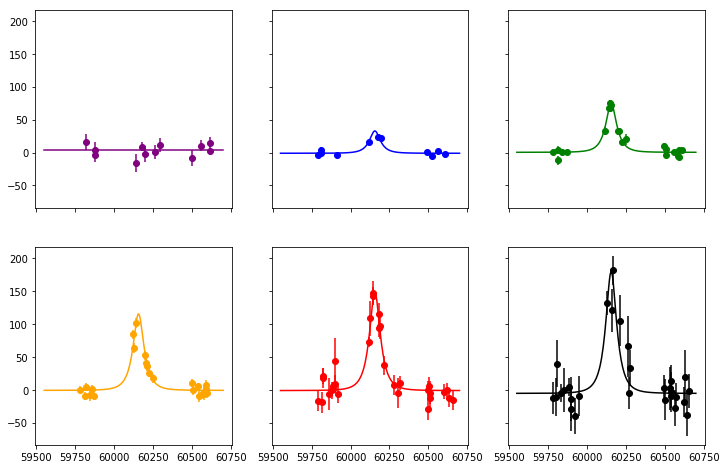

In [17]:
iobj=train_metadata[(train_metadata['target']==6) & (train_metadata['ddf']==0)].index[5]

params = fit_microlens(times_list[iobj],flux_list[iobj],err_list[iobj]) 
plot_microlens(times_list[iobj],flux_list[iobj],err_list[iobj],params[:2])


# Proceeding to the fit on all galactic training data
... this will take some time

Note that we don't fit for extragalactic objects to save computation time.

In [19]:
def make_microparams():
    microparams_list=[0]*len(train_metadata)
    
    for iobj in train_metadata[(train_metadata['hostgal_photoz']==0)].index:
        if iobj%100==0: print(iobj)
        microparams_list[iobj] = fit_microlens(times_list[iobj],flux_list[iobj],err_list[iobj])

    return microparams_list

A few warnings will get issued : those are cases of failed fits...
    
Time for a coffee... or to go runing on a decent multicore machine.

In [20]:
microparams=make_microparams()

# then put things into array variables
microamp = np.zeros((len(train_metadata),6))
microbase = np.zeros((len(train_metadata),6))
microt0 = np.zeros(len(train_metadata))
microte = np.zeros(len(train_metadata))
microwings = np.zeros(len(train_metadata))
microchi2 = np.zeros(len(train_metadata))
microndf = np.zeros(len(train_metadata))
for iobj in train_metadata[(train_metadata['hostgal_photoz']==0)].index:
    microamp[iobj] = microparams[iobj][0][:,0]
    microbase[iobj] = microparams[iobj][0][:,1]
    microt0[iobj] = np.abs(microparams[iobj][1][0])
    microte[iobj] = np.abs(microparams[iobj][1][1])
    microwings[iobj] = microparams[iobj][1][2]
    microchi2[iobj] = microparams[iobj][2]
    microndf[iobj] = microparams[iobj][3]-15

0


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  
/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in multiply
  import sys
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


700
1100
1300
1500
1700
2000
2700
3200
3300
3400
3800
4200
5000
5200
6000
6500
6800
7300
7400
7500
7700


## Analysis of the results

Here we present $chi2/ndf$ vs $t_E$ (time width of the event) on a log-log scale.
Different classes will get different colors.

As expected, class 6 members have $chi2/ndf$ around 1.

Good news is that this plot also helps to separate other galactic classes.
Also, the class 65 (orange) natural false-positive on chi2 have very different time width.

I Hope that using the whole 15+1 extracted features will help your classifications !


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


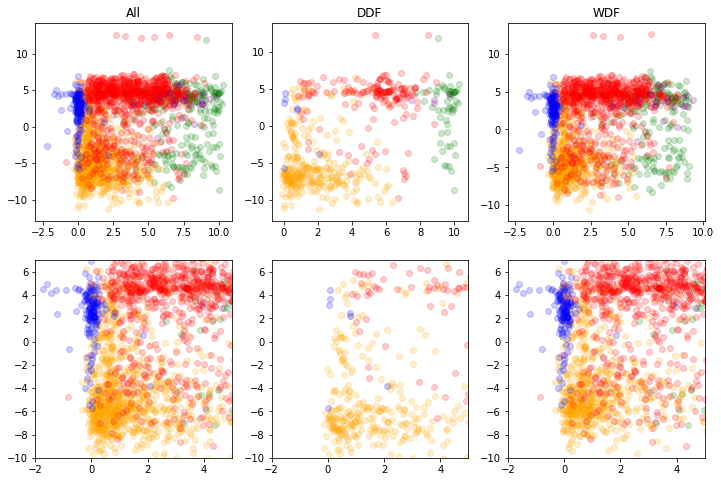

In [21]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for t in gal_target:
#for t in [6]:
    plotx=np.log(microchi2 / microndf)
    ploty=np.log(microte)
    ax = axes[0,0]
    ax.scatter(plotx[t_type[t]],ploty[t_type[t]],color=t_colors[t],alpha=0.2)
    ax = axes[0,1]
    ax.scatter(plotx[ddf_type[t]],ploty[ddf_type[t]],color=t_colors[t],alpha=0.2)
    ax = axes[0,2]
    ax.scatter(plotx[wdf_type[t]],ploty[wdf_type[t]],color=t_colors[t],alpha=0.2)
    ax = axes[1,0]
    ax.scatter(plotx[t_type[t]],ploty[t_type[t]],color=t_colors[t],alpha=0.2)
    ax = axes[1,1]
    ax.scatter(plotx[ddf_type[t]],ploty[ddf_type[t]],color=t_colors[t],alpha=0.2)
    ax = axes[1,2]
    ax.scatter(plotx[wdf_type[t]],ploty[wdf_type[t]],color=t_colors[t],alpha=0.2)


ax = axes[0,0]
ax.set_title("All")
ax = axes[0,1]
ax.set_title("DDF")
ax = axes[0,2]
ax.set_title("WDF")
for i in range(3):
    ax = axes[1,i]
    ax.set_xlim((-2,5))
    ax.set_ylim((-10,7))

## Writing output to cvs file

Metrics are for now
- maxsigma, frac3sigma, undersigma, fracunder, ls_frequency,ls_power, microt0, microte, microwings, microchi2, microndf

And per band:
- stds, medians,err_median, microbase, microamp 

In [22]:

train_metadata['micro_t0'] = microt0
train_metadata['micro_te'] = microte
train_metadata['micro_wings'] = microwings
train_metadata['micro_chi2'] = microchi2
train_metadata['micro_ndf'] = microndf
train_metadata['microbase']=train_metadata.apply(lambda x : microbase[x.name],axis=1)
train_metadata['microamp']=train_metadata.apply(lambda x : microamp[x.name],axis=1)



In [23]:
train_metadata.to_csv('training_set_metadata_microlensed.csv')

# This is the end !

I hope that using the whole 15+1 extracted features will help you with your classifications.
Enjoy !